Welcome to my attempt at the Intelinair CVPR challenge! The goal is to do semantic segmentation of the images provided. 

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten 
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, ELU, Conv3D, ConvLSTM2D 
from tensorflow.keras.layers import UpSampling2D, Concatenate
from tensorflow.keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import random
import cv2
import sys

In [32]:
input_img0_names = []
input_img1_names = []
input_img2_names = []
boundary_mask_names = []
nutrient_mask_names = []

HEIGHT = 256
WIDTH = 256
CHANNELS = 3
BATCH_SIZE = 16
src_dir = '/home/garrett/Documents/IntelinAirData/Longitudinal_Nutrient_Deficiency'

for i in range(1,387):
    filestring = str(i).zfill(3)
    input_img0_names.append(os.path.join(src_dir, f'field_{filestring}/image_i0.png'))
    input_img1_names.append(os.path.join(src_dir, f'field_{filestring}/image_i1.png'))
    input_img2_names.append(os.path.join(src_dir, f'field_{filestring}/image_i2.png'))
    boundary_mask_names.append(os.path.join(src_dir, f'field_{filestring}/bounday_mask.png'))
    nutrient_mask_names.append(os.path.join(src_dir, f'field_{filestring}/nutrient_mask_g0.png'))
    
df = pd.DataFrame({'image_0':input_img0_names , 'image_1':input_img1_names, 'image_2':input_img2_names, 
                   'boundary_mask':boundary_mask_names, 'nutrient_mask':nutrient_mask_names})
#df.reset_index(drop=True, inplace=True)
df.head(5)

XY_train,XY_valtest = train_test_split(df, train_size=0.8, random_state=0)
XY_val, XY_test = train_test_split(XY_valtest, train_size=0.5, random_state=0)
XY_train.reset_index(drop=True, inplace=True)
XY_val.reset_index(drop=True, inplace=True)
XY_test.reset_index(drop=True, inplace=True)
XY_train.head(5)

,image_0,image_1,image_2,boundary_mask,nutrient_mask
0,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...
1,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...
2,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...
3,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...
4,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...,/home/garrett/Documents/IntelinAirData/Longitu...


(-0.5, 898.5, 1107.5, -0.5)

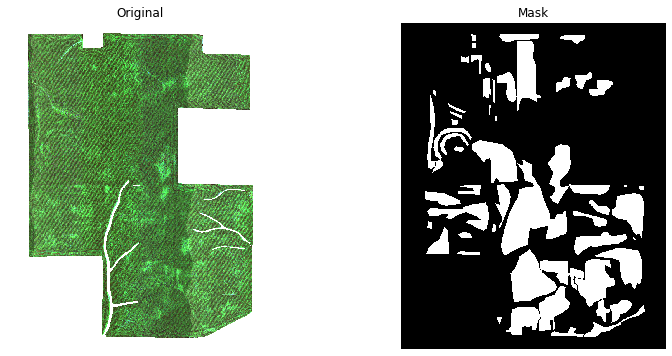

In [33]:
index = random.randint(0, len(XY_train)-1)
img = cv2.imread(XY_train.loc[index].at["image_0"])
mask = cv2.imread(XY_train.loc[index].at["nutrient_mask"])
npmask = np.array(mask)
plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(132)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

In [34]:
image0_train_datagen = ImageDataGenerator(rescale=1./255.)
image1_train_datagen = ImageDataGenerator(rescale=1./255.)
image2_train_datagen = ImageDataGenerator(rescale=1./255.)
mask_train_datagen = ImageDataGenerator(rescale=1./255.)

image0_val_datagen = ImageDataGenerator(rescale=1./255.)
image1_val_datagen = ImageDataGenerator(rescale=1./255.)
image2_val_datagen = ImageDataGenerator(rescale=1./255.)
mask_val_datagen = ImageDataGenerator(rescale=1./255.)

In [35]:
seed = 1

image0_train_generator = image0_train_datagen.flow_from_dataframe(
    dataframe=XY_train,
    x_col="image_0",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

image1_train_generator = image1_train_datagen.flow_from_dataframe(
    dataframe=XY_train,
    x_col="image_1",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

image2_train_generator = image2_train_datagen.flow_from_dataframe(
    dataframe=XY_train,
    x_col="image_2",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

mask_train_generator = mask_train_datagen.flow_from_dataframe(
    dataframe=XY_train,
    x_col="nutrient_mask",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image0_train_generator, image1_train_generator, image2_train_generator, mask_train_generator)

Found 308 validated image filenames.
Found 308 validated image filenames.
Found 308 validated image filenames.
Found 308 validated image filenames.


In [36]:
seed = 1

image0_val_generator = image0_val_datagen.flow_from_dataframe(
    dataframe=XY_val,
    x_col="image_0",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

image1_val_generator = image1_val_datagen.flow_from_dataframe(
    dataframe=XY_val,
    x_col="image_1",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

image2_val_generator = image2_val_datagen.flow_from_dataframe(
    dataframe=XY_val,
    x_col="image_2",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

mask_val_generator = mask_val_datagen.flow_from_dataframe(
    dataframe=XY_val,
    x_col="nutrient_mask",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)

# combine generators into one which yields image and masks
val_generator = zip(image0_val_generator, image1_val_generator, image2_val_generator, mask_val_generator)

Found 39 validated image filenames.
Found 39 validated image filenames.
Found 39 validated image filenames.
Found 39 validated image filenames.


In [37]:
def UNet(image_input):

    ''' ~~~~~~~~~~~~~~~~~~~ ENCODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

    c1 = Conv2D(32, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(image_input)
    c1 = ELU()(c1)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(32, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c1)
    c1 = ELU()(c1)
    c1 = BatchNormalization()(c1)
    
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32*2, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(p1)
    c2 = ELU()(c2)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(32*2, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c2)
    c2 = ELU()(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2,2))(c2)
    

    c3 = Conv2D(32*4, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(p2)
    c3 = ELU()(c3)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(32*2, kernel_size=(1,1), kernel_initializer='he_normal', padding = 'same')(c3)
    c3 = ELU()(c3)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(32*4, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c3)
    c3 = ELU()(c3)
    c3 = BatchNormalization()(c3)

    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(32*6, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(p3)
    c4 = ELU()(c4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(32*4, kernel_size=(1,1), kernel_initializer='he_normal', padding = 'same')(c4)
    c4 = ELU()(c4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(32*6, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c4)
    c4 = ELU()(c4)
    c4 = BatchNormalization()(c4)

    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(32*6, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(p4)
    c5 = ELU()(c5)
    c5 = BatchNormalization()(c5)


    ''' ~~~~~~~~~~~~~~~~~~~ DECODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

    u1 = UpSampling2D((2,2))(c5)
    concat1 = Concatenate()([c4, u1])

    c6 = Conv2D(32*4, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(concat1)
    c6 = ELU()(c6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(32*4, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c6)
    c6 = ELU()(c6)
    c6 = BatchNormalization()(c6)


    u2 = UpSampling2D((2,2))(c6)
    concat2 = Concatenate()([c3, u2])

    c7 = Conv2D(32*2, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(concat2)
    c7 = ELU()(c7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(32*2, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c7)
    c7 = ELU()(c7)
    c7 = BatchNormalization()(c7)

    u3 = UpSampling2D((2,2))(c7)
    concat3 = Concatenate()([c2, u3])

    c8 = Conv2D(32, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(concat3)
    c8 = ELU()(c8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(32, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c8)
    c8 = ELU()(c8)
    c8 = BatchNormalization()(c8)

    u4 = UpSampling2D((2,2))(c8)
    concat4 = Concatenate()([c1, u4])

    c9 = Conv2D(16, kernel_size = (1,1), kernel_initializer='he_normal', padding = 'same')(concat4)
    c9 = ELU()(c9)
    c9 = BatchNormalization()(c9)

    mask_out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding = 'same', activation = 'sigmoid', name = 'mask_out')(c9)
    
    return mask_out

In [50]:
def ConvLSTM(movieIn):
    
    x = ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="elu",
    )(movieIn)

    x = BatchNormalization()(x)
    
    x = ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="elu",
    )(x)
    
    x = BatchNormalization()(x)
    
    x = ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="elu",
    )(x)
    
    x = BatchNormalization()(x)
    
    x = Conv3D(
    filters=1,
    kernel_size=(3, 3, 3),
    activation="sigmoid",
    padding="same"
    )(x)
    
    return lastmask

In [57]:
def FullModel():

    image0 = Input(shape=(HEIGHT, WIDTH, CHANNELS), name = 'img0_input')
    image1 = Input(shape=(HEIGHT, WIDTH, CHANNELS), name = 'img1_input')
    image2 = Input(shape=(HEIGHT, WIDTH, CHANNELS), name = 'img2_input')
    print(image0.shape)
    X1= UNet(image0)
    X2= UNet(image1)
    X3= UNet(image2)
    print(X1.shape)

    movie=Concatenate()([X1, X2, X3])
    print(movie.shape)
    
    outmask = ConvLSTM(movie)
    
    return outmask

In [58]:
def lrfn(epoch):
    if epoch > 15:
        return 2e-4
    elif epoch > 25:
        return 1e-4
    return 1e-3

In [59]:
opt_adam = optimizers.Adam()
model = FullModel()
model.compile(optimizer = opt_adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

(None, 256, 256, 3)
(None, 256, 256, 1)
(None, 256, 256, 3)


ValueError: Input 0 of layer conv_lst_m2d_4 is incompatible with the layer: expected ndim=5, found ndim=4. Full shape received: (None, 256, 256, 3)